# Over-seeding Experiment

In this experiment, I spread an entire packet of carrot seeds in a small area, disregarding the standard 1 inch per seed guidance.  The seeds were planted 2018-03-31 and the carrots were harvested on 2018-07-14, so on the long end 80 day cycle.

Below I outline a simple model for the yield (lbs of carrots per ft^2).

In [67]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [50]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pymc3 as pm
import seaborn as sns
sns.set(color_codes=True)

From memory, the carrot seeds were [
Organic, Heirloom Danver 126](https://www.botanicalinterests.com/product/Danvers-126-Carrot-Seeds/view-all-vegetables). Those packets contain approximately 1 gram of seeds and claim to seed 42 feet with a recommended seed spacing of 1 inch.

In [59]:
mean_seed_count = 42*12
print('Expecting {} seeds'.format(mean_seed_count))

Expecting 504 seeds


Let's assume that the actual seed count canvary from the mean by 50 seeds.

In [60]:
seed_uncertainty = 50

I found the following [yield estimates](http://sustainable-farming.rutgers.edu/wp-content/uploads/2017/12/urbanfringe-v07n01.pdf) (itself an adaptation from Stoner and Smith (1978)) for carrots: 0.5-0.8 (lb/ft^2).

Alternatively, [yardener.com](https://gardening.yardener.com/Carrots) gives an estimate of 1 to 1.7 (lb/ft^2). 

In [162]:
target_yield_per_square_foot = 1.7

I used a [medium, raised garden bed Vegepod](https://vegepod.com/collections/raised-garden-beds/products/raised-garden-bed-medium) to plant carrots, green onions, yellow onions, cilantro, basil, and habenaros.  The raised bed is approximately 1 square meter in area.

In [62]:
garden_area = 10.7639 # in ft^2

I am fairly confident that I used at least 25% and at most 33% of the garden area to spread carrot seeds.

In [63]:
min_carrot_area = 0.25 * garden_area
max_carrot_area = 0.33 * garden_area

There are only 3 valid classes of carrot use:
- in chicken soup
- in stew
- appetizers (e.g. carmelized)
- everything else (Rukmini Iyer recommends [carrot halwa](https://indianhealthyrecipes.com/carrot-halwa-recipe-gajar-ka-halwa-recipe/))

As far as I am concerned, carrots can be partitioned by the class of use they fall in.  I categorize roughly by size:

| Category | Size |
| --- | --- |
| Soup | Big |
| Stew | Medium |
| Appetizer | Small |
| Garbage bin | Extra small |

Using human judgments, I have the following data from this experiment.  Weight is given in ounces using a kitchen scale.  Length is in centimeters using iOS 12's _Measurement_ app.

First, we have the soup carrots.

In [2]:
soup_carrots = pd.DataFrame([
    {'weight':0.75, 'length':8},
    {'weight':1.25, 'length':9},
    {'weight':2.75, 'length':11},
    {'weight':1.625, 'length':10},
    {'weight':2.25, 'length':13},
    {'weight':1.375, 'length':12},
    {'weight':1.125, 'length':10},
    {'weight':1.25, 'length':7},
    {'weight':2.625, 'length':13},
    {'weight':1.375, 'length':10},
    {'weight':1.75, 'length':9},
    {'weight':0.75, 'length':11},
    {'weight':1.125, 'length':7},
    {'weight':1.375, 'length':12},
    {'weight':0.75, 'length':10},
    {'weight':1, 'length':8},
    {'weight':1.25, 'length':8},
    {'weight':0.75, 'length':8},
    {'weight':1, 'length':9},
    {'weight':1, 'length':8},
    {'weight':0.75, 'length':8},
    {'weight':0.75, 'length':8},
    {'weight':0.75, 'length':8},
    {'weight':0.75, 'length':8},
    {'weight':0.75, 'length':8},
    {'weight':0.625, 'length':10},
    {'weight':1.125, 'length':11},
    {'weight':1.125, 'length':11}])

Below is the histogram of the weight and length of the sample soup carrots.

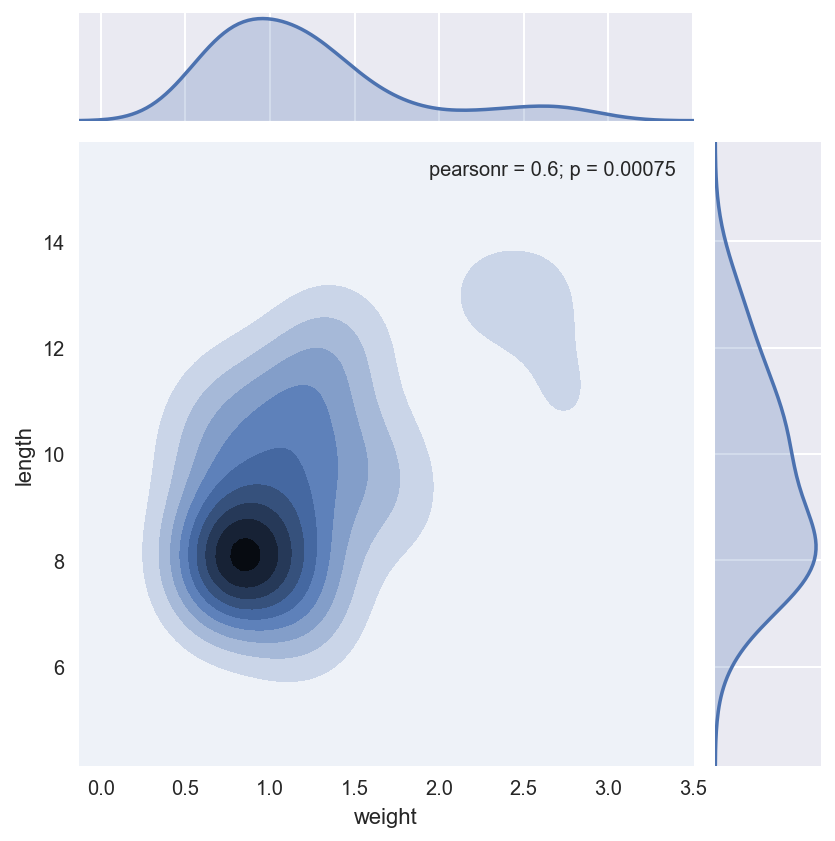

In [52]:
sns.jointplot(x='weight',y='length', data=soup_carrots, kind="kde");

I sampled 10 carrots from the container of classified stew carrots. It appears that I classify stew carrots roughly by length, as they were indistinguishable by the iOS app.

In [12]:
stew_carrot_sample = pd.DataFrame([
    {'weight':0.75, 'length':7},
    {'weight':0.625, 'length':7},
    {'weight':0.375, 'length':7},
    {'weight':0.375, 'length':7},
    {'weight':0.375, 'length':7},
    {'weight':0.5, 'length':7},
    {'weight':0.375, 'length':7},
    {'weight':0.375, 'length':7},
    {'weight':0.25, 'length':7},
    {'weight':0.25, 'length':7}])

The weight distribution of stew carrots is given below:

/anaconda3/envs/analysis/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


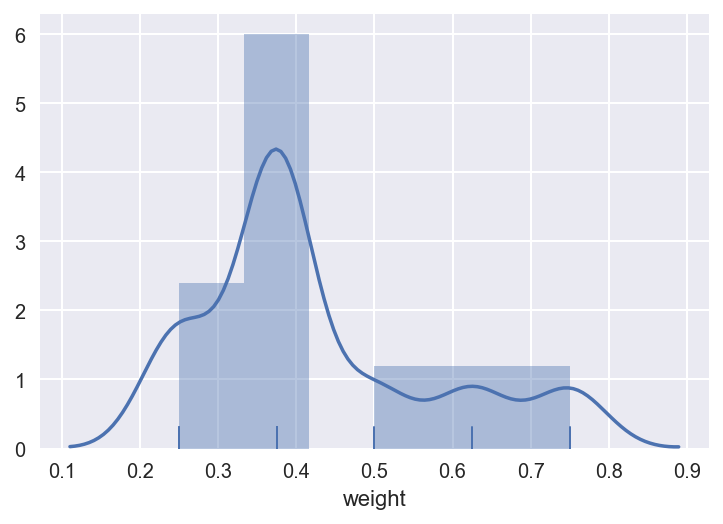

In [55]:
sns.distplot(stew_carrot_sample.weight, rug=True);

I took aggregate measurements for each class, as well as the bowl containing the carrots (same in each case) and all of the carrots.

| Description | Weight (oz) | Carrot Samples |
| --- | --- | --- |
| Blue Bowl | 8.375 | 0 |
| Soup + Bowl | 41.875 | 28 |
| Stew+Bowl | 43.25 | 86 |
| Appetizer+Bowl | 30.25 | 119 |
| Garbage bin+Bowl | 17.25 | 185 |
| All+Bowl | 107.75 | 418 | 	


In [106]:
bowl_weight = 8.375
measured_total_carrot_weight = 107.25 - bowl_weight

aggregate_carrots = pd.DataFrame([
  {'category':'soup', 'weight': (41.875-bowl_weight), 'samples': 28},
  {'category':'stew', 'weight': (43.25-bowl_weight), 'samples': 86},
  {'category':'appetizer', 'weight': (30.25-bowl_weight), 'samples': 119},
  {'category':'garbage_bin', 'weight': (17.25-bowl_weight), 'samples': 185}]).set_index('category')

Mean weight-per-carrot by class:

In [138]:
aggregate_carrots['mean_weight_per_carrot'] = aggregate_carrots.weight/aggregate_carrots.samples
aggregate_carrots['mean_weight_per_carrot']

category
soup           1.196429
stew           0.405523
appetizer      0.183824
garbage_bin    0.047973
Name: mean_weight_per_carrot, dtype: float64

The aggregate weight and counts of carrots is given by:

In [107]:
aggregate_carrots[['weight','samples']].sum()

weight      99.125
samples    418.000
dtype: float64

Measurement error for total carrot weight:

In [108]:
calculated_total_carror_weight = aggregate_carrots.weight.sum() 
print('{} oz ({:.3f}%)'.format(
    calculated_total_carror_weight - measured_total_carrot_weight, 
    100.0*(calculated_total_carror_weight/measured_total_carrot_weight-1.0)))

0.25 oz (0.253%)


From the above, we can calculate a point estimate for the yield (lb/ft^2):

In [117]:
measured_total_carrot_weight/ 16.0 / (0.5*(min_carrot_area + max_carrot_area))

1.979697622737048

This is above the high end for the yield estimates.  Let's look at the same estimate if we remove the garbage bin class.

In [161]:
(measured_total_carrot_weight - aggregate_carrots.loc['garbage_bin'].weight) / 16.0 / (0.5*(min_carrot_area + max_carrot_area))

1.802000364564696

Next, we look at a simple Bayesian model for carrot yield.

In [153]:
basic_model = pm.Model()

with basic_model:
    carrot_area = pm.Uniform('carrot_area',
                             min_carrot_area, 
                             max_carrot_area)
    
    carrot_seeds = pm.Uniform('carrot_seeds',
                              mean_seed_count-seed_uncertainty, 
                              mean_seed_count+seed_uncertainty)
    
    soup_carrot_grow_rate = pm.Uniform('soup_carrot_grow_rate', 0, 1)
    stew_carrot_grow_rate = pm.Uniform('stew_carrot_grow_rate', 0, 1)
    appetizer_carrot_grow_rate = pm.Uniform('appetizer_carrot_grow_rate', 0, 1)
    garbage_bin_carrot_grow_rate = pm.Uniform('garbage_bin_carrot_grow_rate', 0, 1)
        
    soup_carrot_counts = pm.Binomial('soup_carrot_counts',
                              n=carrot_seeds,
                              p=soup_carrot_grow_rate,
                              observed=aggregate_carrots.loc['soup'].samples)
    stew_carrot_counts = pm.Binomial('stew_carrot_counts',
                              n=carrot_seeds,
                              p=stew_carrot_grow_rate,
                              observed=aggregate_carrots.loc['stew'].samples)
    appetizer_carrot_counts = pm.Binomial('appetizer_carrot_counts',
                              n=carrot_seeds,
                              p=appetizer_carrot_grow_rate,
                              observed=aggregate_carrots.loc['appetizer'].samples)
    garbage_bin_carrot_counts = pm.Binomial('garbage_bin_carrot_counts',
                              n=carrot_seeds,
                              p=garbage_bin_carrot_grow_rate,
                              observed=aggregate_carrots.loc['garbage_bin'].samples)
    
    mu_soup_carrot_weight = pm.Exponential('mu_soup_carrot_weight',1)
    sigma_soup_carrot_weight = pm.Exponential('sigma_soup_carrot_weight',1)
    nu_soup_carrot_weight = pm.Exponential('nu_soup_carrot_weight', 1/10.)
    
    mu_stew_carrot_weight = pm.Exponential('mu_stew_carrot_weight',1)
    sigma_stew_carrot_weight = pm.Exponential('sigma_stew_carrot_weight',1)
    nu_stew_carrot_weight = pm.Exponential('nu_stew_carrot_weight', 1/10.)
    
    soup_carrot_weight = pm.StudentT('soup_carrot_weight',
                            nu=nu_soup_carrot_weight,
                            mu=mu_soup_carrot_weight, 
                            sd=sigma_soup_carrot_weight, 
                            observed=soup_carrots.weight.values)
    
    stew_carrot_weight = pm.StudentT('stew_carrot_weight', 
                            nu=nu_stew_carrot_weight,
                            mu=mu_stew_carrot_weight, 
                            sd=sigma_stew_carrot_weight, 
                            observed=stew_carrot_sample.weight.values)
    
    total_soup_carrot_weight_in_lbs = mu_soup_carrot_weight*carrot_seeds*soup_carrot_grow_rate/16.0
    total_stew_carrot_weight_in_lbs = mu_stew_carrot_weight*carrot_seeds*stew_carrot_grow_rate/16.0
    total_appetizer_carrot_weight_in_lbs = aggregate_carrots.loc['appetizer'].mean_weight_per_carrot * \
                                           carrot_seeds*appetizer_carrot_grow_rate/16.0
    
    tota_carrot_weight_in_lbs = total_soup_carrot_weight_in_lbs + \
                                total_stew_carrot_weight_in_lbs + \
                                total_appetizer_carrot_weight_in_lbs
    
    pm.Deterministic('soup_carrot_yield',total_soup_carrot_weight_in_lbs/carrot_area)
    pm.Deterministic('stew_carrot_yield', total_stew_carrot_weight_in_lbs/carrot_area)
    pm.Deterministic('appetizer_carrot_yield', total_appetizer_carrot_weight_in_lbs/carrot_area)
    pm.Deterministic('carrot_yield', tota_carrot_weight_in_lbs/carrot_area)
    
    #map_estimate = pm.find_MAP(model=basic_model)
    trace = pm.sample(1000, tune=1000) #start=map_estimate)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_stew_carrot_weight_log__, sigma_stew_carrot_weight_log__, mu_stew_carrot_weight_log__, nu_soup_carrot_weight_log__, sigma_soup_carrot_weight_log__, mu_soup_carrot_weight_log__, garbage_bin_carrot_grow_rate_interval__, appetizer_carrot_grow_rate_interval__, stew_carrot_grow_rate_interval__, soup_carrot_grow_rate_interval__, carrot_seeds_interval__, carrot_area_interval__]
100%|██████████| 2000/2000 [00:09<00:00, 215.63it/s]


This produces the following trace plots.

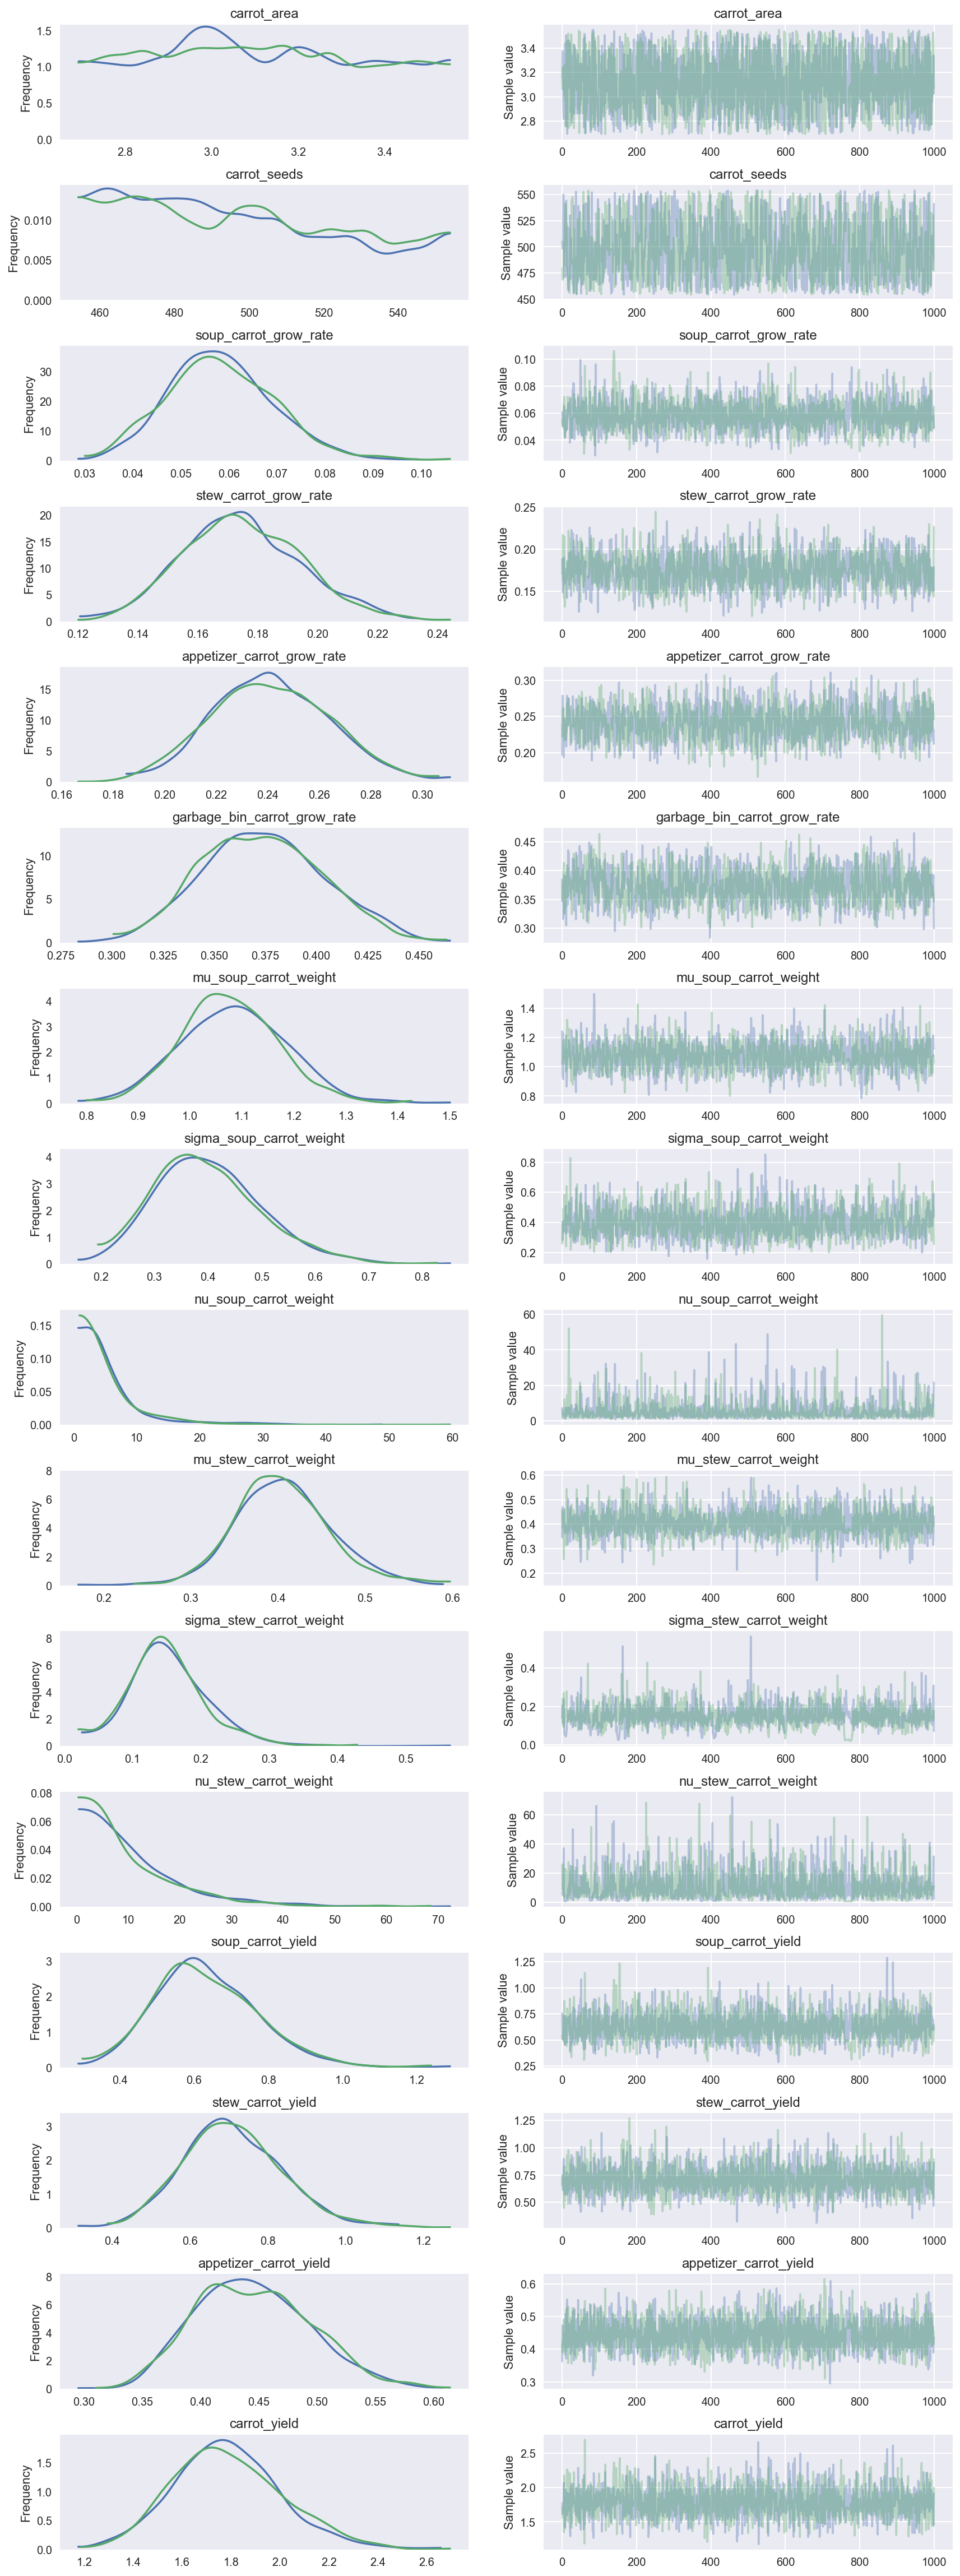

In [154]:
pm.traceplot(trace);

Specifically, we focus on the yield variables.

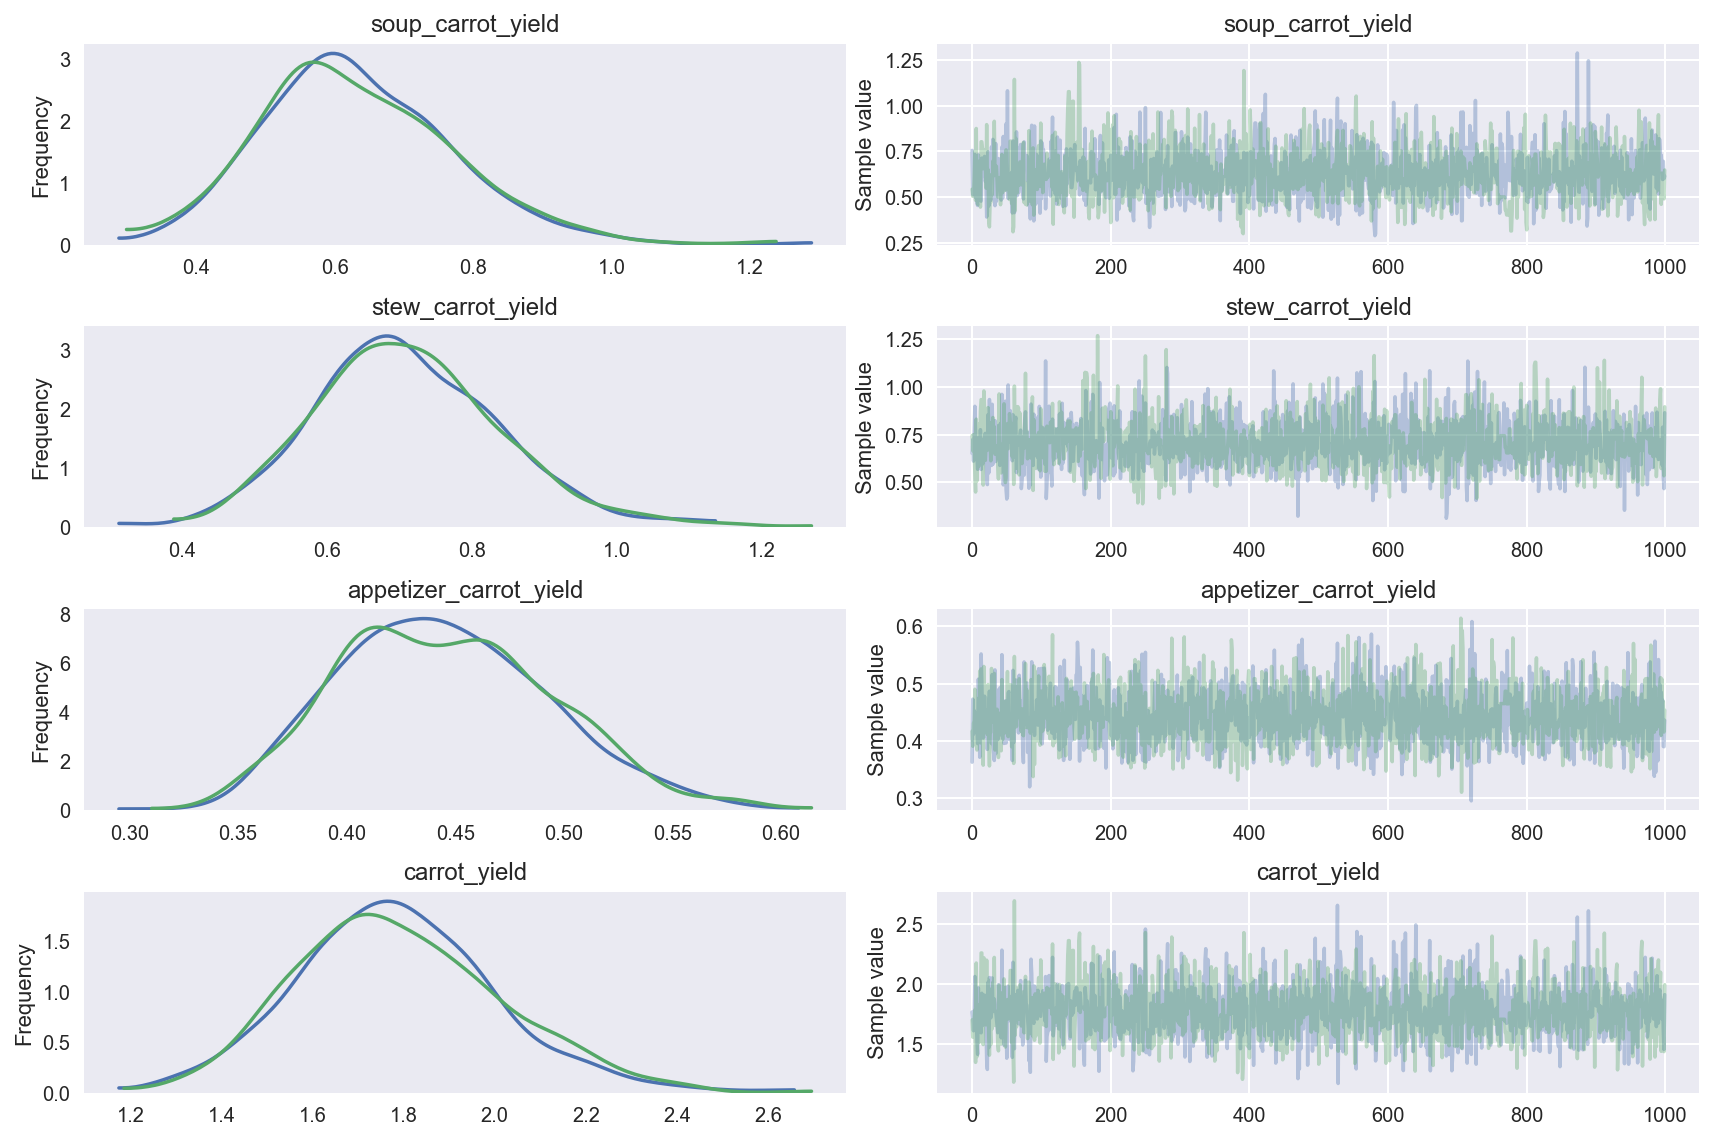

In [155]:
pm.traceplot(
    trace, 
    varnames=[
        'soup_carrot_yield',
        'stew_carrot_yield',
        'appetizer_carrot_yield',
        'carrot_yield']);

Probability that our yield is higher than the target yield:

In [163]:
np.mean(trace["carrot_yield"] > target_yield_per_square_foot)

0.6325

Alternatively, we can calculate the probability that the yield is higher than the lower end of the yield estimate:

In [165]:
np.mean(trace["carrot_yield"] > 1)

1.0

### Model Checks

In [158]:
pm.gelman_rubin(trace)

{'appetizer_carrot_grow_rate': 0.999736817753602,
 'appetizer_carrot_yield': 0.9996921819705118,
 'carrot_area': 0.9995577112176697,
 'carrot_seeds': 1.001280256016118,
 'carrot_yield': 0.9996604419414211,
 'garbage_bin_carrot_grow_rate': 1.0000897458828644,
 'mu_soup_carrot_weight': 1.0019805193537215,
 'mu_stew_carrot_weight': 0.9996573683093469,
 'nu_soup_carrot_weight': 0.9998362610203002,
 'nu_stew_carrot_weight': 1.0011128348061769,
 'sigma_soup_carrot_weight': 1.0000840824188237,
 'sigma_stew_carrot_weight': 1.0017016910166863,
 'soup_carrot_grow_rate': 0.9995108841728741,
 'soup_carrot_yield': 0.999505935594282,
 'stew_carrot_grow_rate': 0.9997955727791056,
 'stew_carrot_yield': 0.999865525921126}

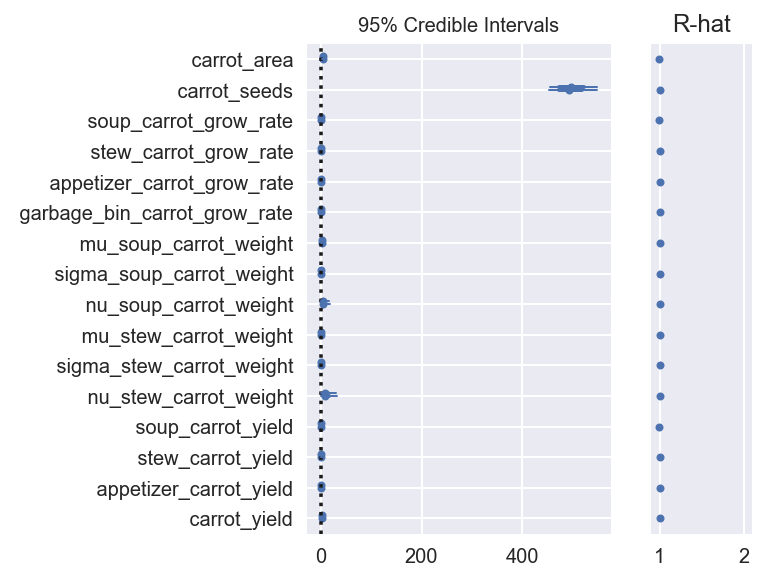

In [159]:
pm.forestplot(trace)